![Aeropython Logo](/files/imagenes/aeropython_logo.png)

#Resolviendo un Laberinto

El problema es muy sencillo: tenemos un laberinto, y deseamos que nuestro algoritmo genético encuentre la salida

Empecemos importando los paquetes necesarios y creando el laberinto:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Esta matriz describe las fronteras de cada casilla con cada número en binario:
#primer dígito binario: frontera superior
#segundo dígito binario: frontera derecha
#tercer dígito binario: frontera inferior
#cuarto dígito binario: frontera izquierda
#Para cada dígito: 1 = frontera cerrada, 0 = frontera abierta
grid = np.array([
        [9, 3, 9, 5, 5, 5, 5, 5, 5, 3],
        [10, 12, 6, 9, 1, 5, 5, 3, 9, 6],
        [10, 9, 3, 10, 10, 9, 3, 10, 10, 11],
        [10, 10, 10, 10, 10, 12, 6, 10, 8, 2],
        [8, 2, 8, 6, 12, 5, 5, 6, 10, 12],
        [10, 10, 12, 1, 5, 5, 1, 3, 12, 3],
        [10, 12, 3, 10, 9, 5, 6, 12, 3, 10],
        [8, 5, 6, 10, 10, 9, 3, 11, 10, 10],
        [10, 9, 3, 10, 12, 6, 12, 2, 10, 10],
        [12, 6, 12, 4, 5, 5, 5, 6, 12, 6]
    ])

#Esta matriz simplemente es un damero que sirve para pintarlo bonito
back = np.zeros([10,10])
back[::2, ::2] = 1
back[1::2, 1::2] = 1

Pintemos el laberinto!

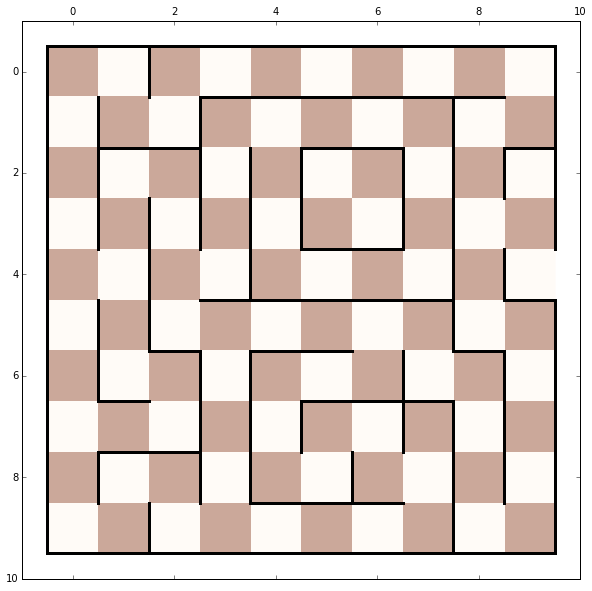

In [3]:
plt.figure(1, figsize=(10,10))
plt.matshow(back, fignum= 1, cmap=plt.cm.Oranges, alpha = 0.4)
#plt.contourf(xx, yy, back, np.linspace(-1, 2, 3), cmap=plt.cm.Blues)
plt.xlim(-1,10)
plt.ylim(-1,10)
x = list(range(10))
y = x
for i in x:
    for j in y:
        if grid[j,i] & 1 :
            xx = i + np.array([-0.5,  0.5])
            yy = j + np.array([-0.5,-0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 2 :
            xx = i + np.array([ 0.5, 0.5])
            yy = j + np.array([-0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 4 :
            xx = i + np.array([-0.5, 0.5])
            yy = j + np.array([ 0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 8 :
            xx = i + np.array([-0.5,-0.5])
            yy = j + np.array([-0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
plt.gca().invert_yaxis()            
            


Queda chulo, ¿verdad?

## Creando un camino a partir de un genoma

Ahora viene una cuestión interesante: ¿Cómo definimos un camino a partir de un genoma?

La respuesta es simple:

Para cada casilla, el genoma nos designa una dirección, en la que un viajero intentaría moverse una vez que ha llegado a esa casilla.

Veamos cómo quedaría:

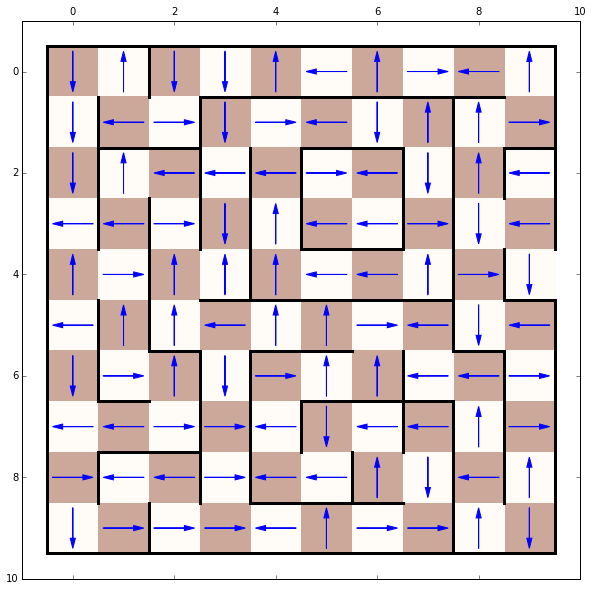

In [4]:
gen = np.random.randint(0,2,200)
gen2 = gen.reshape((100,-1))
directions = (2 * gen2[:,0] + gen2[:,1]).reshape((10,10))


plt.figure(1, figsize=(10,10))
plt.matshow(back, fignum= 1, cmap=plt.cm.Oranges, alpha = 0.4)
#plt.contourf(xx, yy, back, np.linspace(-1, 2, 3), cmap=plt.cm.Blues)
plt.xlim(-1,10)
plt.ylim(-1,10)
x = list(range(10))
y = x
for i in x:
    for j in y:
        if grid[j,i] & 1 :
            xx = i + np.array([-0.5,  0.5])
            yy = j + np.array([-0.5,-0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 2 :
            xx = i + np.array([ 0.5, 0.5])
            yy = j + np.array([-0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 4 :
            xx = i + np.array([-0.5, 0.5])
            yy = j + np.array([ 0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        if grid[j,i] & 8 :
            xx = i + np.array([-0.5,-0.5])
            yy = j + np.array([-0.5, 0.5])
            plt.plot(xx,yy, 'k', linewidth=3)
        
        if directions[j ,i] == 0:
            plt.arrow(i, j + 0.4, 0, -0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
        if directions[j ,i] == 1:
            plt.arrow(i - 0.4, j,  0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')
        if directions[j ,i] == 2:
            plt.arrow(i, j - 0.4, 0,  0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
        if directions[j ,i] == 3:
            plt.arrow(i + 0.4, j, -0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')
plt.gca().invert_yaxis()            
            


Un viajero que intentara seguir estas indicaciones, estaría en un buen apuro. Veamos como podría recorrerlo:


- Si la dirección de la casilla le dice que intente atravesar una pared, el viajero intentará otra dirección aleatoria.

- El viajero tendrá una cantidad limitada de pasos.

Definimos las funciones necesarias para generar un camino a partir del genoma:

In [5]:
def move(row, col, direction):
    d = 2 ** direction
    
    if not grid[row, col] & d:
        
        if direction == 0:
            return row -1, col
        elif direction == 1:
            return row , col+1
        elif direction == 2:
            return row +1, col
        elif direction == 3:
            return row , col-1
    else:
        #print(' valla!', end = '')
        return None

In [6]:
def step(row, col, direction, path):
    wall = False
    #print('[', row,',', col,']', 'd =', direction, end = '')
    newpos = move(row, col, direction)
    if newpos == None:
        wall = True
        new_d = np.random.randint(0,4)
        #print(' otra!: [', row,',', col,']', 'd =', new_d, end = '')
        newpos = move(row, col, new_d)
        
    if newpos != None and  0<= col <=9:
        row,col = newpos
    if len(path) >=2 and [row, col] == path[-2]:
        wall = True
    #print()
    return row, col, wall

In [7]:
def translate_adn(gen):
    gen2 = gen.reshape((100,-1))
    directions = (2 * gen2[:,0] + gen2[:,1]).reshape((10,10))
    return directions

In [8]:
def get_path(gen, max_steps):
    directions = translate_adn(gen)
    path = [[4,0]]
    wallcount = 0
    for nstep in range(max_steps):
        #print('step:', nstep, end=' ')
        row, col = path[nstep]
        row, col, wall = step(row, col, directions[row, col], path)
        wallcount += wall
        path.append([row, col])
        if [row,col] == [4, 10]:
            break
    return path, wallcount

In [9]:
def draw_path(gen, max_steps, alpha = 0.3, num_draw = 0):
    directions = translate_adn(gen)
    path, wallcount = get_path(gen, max_steps)
    path = np.array(path)
    plt.figure(num_draw, figsize=(10,10))
    plt.matshow(back, fignum= num_draw, cmap=plt.cm.Oranges, alpha = 0.4)
    #plt.contourf(xx, yy, back, np.linspace(-1, 2, 3), cmap=plt.cm.Blues)
    plt.xlim(-1,10)
    plt.ylim(-1,10)
    x = list(range(10))
    y = x
    for i in x:
        for j in y:
            if grid[j,i] & 1 :
                xx = i + np.array([-0.5,  0.5])
                yy = j + np.array([-0.5,-0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 2 :
                xx = i + np.array([ 0.5, 0.5])
                yy = j + np.array([-0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 4 :
                xx = i + np.array([-0.5, 0.5])
                yy = j + np.array([ 0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 8 :
                xx = i + np.array([-0.5,-0.5])
                yy = j + np.array([-0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)

            if directions[j ,i] == 0:
                plt.arrow(i, j + 0.4, 0, -0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
            if directions[j ,i] == 1:
                plt.arrow(i - 0.4, j,  0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')
            if directions[j ,i] == 2:
                plt.arrow(i, j - 0.4, 0,  0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
            if directions[j ,i] == 3:
                plt.arrow(i + 0.4, j, -0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')
            #plt.text( i, j, directions[j,i], fontsize=12)
    plt.plot(path[:,1], path[:,0], 'r', linewidth = 8, alpha = alpha)
    plt.gca().invert_yaxis()

Probémoslo!

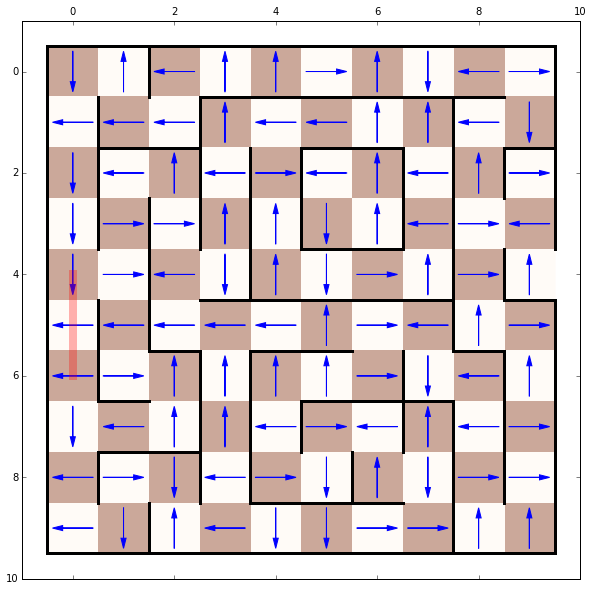

In [10]:
gen = np.random.randint(0,2,200)
max_steps = 5

draw_path(gen, max_steps, 0.5)
#print(translate_adn(gen))
#print(get_path(gen, max_steps))

##Implementando el algoritmo genético

...La verdad es que como camino, no es gran cosa...

Pero tenemos que ir más allá: tenemos que evaluar el camino con una sere de reglas para poder usar el algoritmo genético:

- Cuando el viajero choque con una pared, el camino recibirá una pequeña penalización.

- Si hay dos casillas que se apuntan mutuamente, el viajero quedará atrapado, por lo que también penalizamos volver a la casilla de la que se partió en el turno anterior.

- Queremos llegar a la salida de la derecha, por lo que beneficiaremos a los caminos que dejen al viajero más a la derecha.

- Si un camino conduce a la salida, le daremos una gran bonificación para no perderlo

¡Probemos con estas reglas un algoritmo genético!

In [11]:
def analize(gen, max_steps):
    path, wallcount = get_path(gen, max_steps)
    endx = path[-1][1]
    victory = max_steps + 1 - len(path)
    score = endx * 2 - wallcount + victory * 6
    #print('end x', endx, 'wallcount', wallcount, 'score', score)
    return score

In [12]:
def reproduccion(gen1, gen2, mut):
    lim = np.random.randint(2,len(gen1)-2)
    new = np.zeros_like(gen1)
    new[:lim] = gen1[:lim]
    new[lim:] = gen2[lim:]
    for i in range(len(new)):
        if np.random.randint(0,100) < mut :
            new[i] = 1 - new[i]
    return new


calculando generación 0 población: 200 puntuación media: -36.66

calculando generación 1 población: 200 puntuación media: -33.495

calculando generación 2 población: 200 puntuación media: -30.38

calculando generación 3 población: 200 puntuación media: -29.24

calculando generación 4 población: 200 puntuación media: -27.11

calculando generación 5 población: 200 puntuación media: -26.2

calculando generación 6 población: 200 puntuación media: -22.665

calculando generación 7 población: 200 puntuación media: -22.44

calculando generación 8 población: 200 puntuación media: -19.9

calculando generación 9 población: 200 puntuación media: -19.56

calculando generación 10 población: 200 puntuación media: -17.48

calculando generación 11 población: 200 puntuación media: -16.42

calculando generación 12 población: 200 puntuación media: -12.96

calculando generación 13 población: 200 puntuación media: -13.675

calculando generación 14 población: 200 puntuación media: -13.36

calculando generac

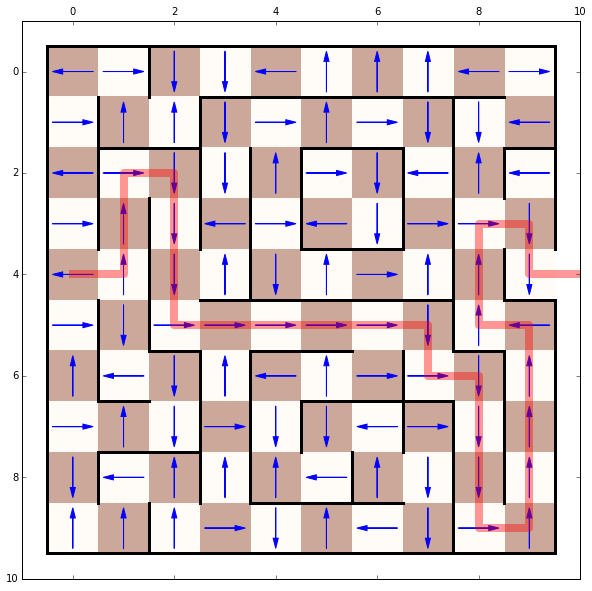

In [13]:
npop = 200
ndeath = 185
numgen = 30
max_steps = 40
mutation = 3
popgen = []


for sol in range(npop):
    gen = np.random.randint(0,2,200)
    popgen.append(gen)

for generation in range(numgen):
    print()
    print('calculando generación', generation, end=' ')
    popscore = []
    for sol in range(npop):
        gen = popgen[sol]
        score = analize(gen, max_steps)
        popscore.append(score)
    print('población:', len(popscore), 'puntuación media:', sum(popscore)/len(popscore))
    for i in range(ndeath):
        minimun = min(popscore)
        weakest = popscore.index(minimun)
        del(popscore[weakest])
        del(popgen[weakest])
    alive = npop - ndeath
    
    #draw_tablero(generation)
    #draw_path(popgen[popscore.index(max(popscore))], max_steps,0.0, generation)
    #print('puntuaciones ganadoras: ', end='')
    for i in range(alive):
        gen = popgen[i]
        #print(popscore[i], end=' ')
        #draw_sol(gen, max_steps, 0.2)
        
    for i in range(ndeath) :
        num1 = np.random.randint(0,alive)
        num2 = np.random.randint(0,alive)
        newgen = reproduccion(popgen[num1], popgen[num2], mutation)
        popgen.append(newgen)
    #popgen = np.array(popgen)
    #popscore = np.array(popscore)
draw_path(popgen[popscore.index(max(popscore))], max_steps,0.4, generation)    

##Otras Funciones

A continuación, otras funciones que podemos usar para representar gráficamente el algoritmo

In [14]:
def draw_sol(gen, max_steps, alpha = 0.3):
    path, wallcount = get_path(gen, max_steps)
    path = np.array(path)
    plt.plot(path[:,1], path[:,0], 'r', linewidth = 8, alpha = alpha)

In [15]:
def draw_tablero(numdraw = 0):
    
    
    plt.figure(numdraw, figsize=(10,10))
    plt.matshow(back, fignum= numdraw, cmap=plt.cm.Oranges, alpha = 0.4)
    #plt.contourf(xx, yy, back, np.linspace(-1, 2, 3), cmap=plt.cm.Blues)
    plt.xlim(-1,10)
    plt.ylim(-1,10)
    x = list(range(10))
    y = x
    for i in x:
        for j in y:
            if grid[j,i] & 1 :
                xx = i + np.array([-0.5,  0.5])
                yy = j + np.array([-0.5,-0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 2 :
                xx = i + np.array([ 0.5, 0.5])
                yy = j + np.array([-0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 4 :
                xx = i + np.array([-0.5, 0.5])
                yy = j + np.array([ 0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)
            if grid[j,i] & 8 :
                xx = i + np.array([-0.5,-0.5])
                yy = j + np.array([-0.5, 0.5])
                plt.plot(xx,yy, 'k', linewidth=3)

    
    plt.gca().invert_yaxis()

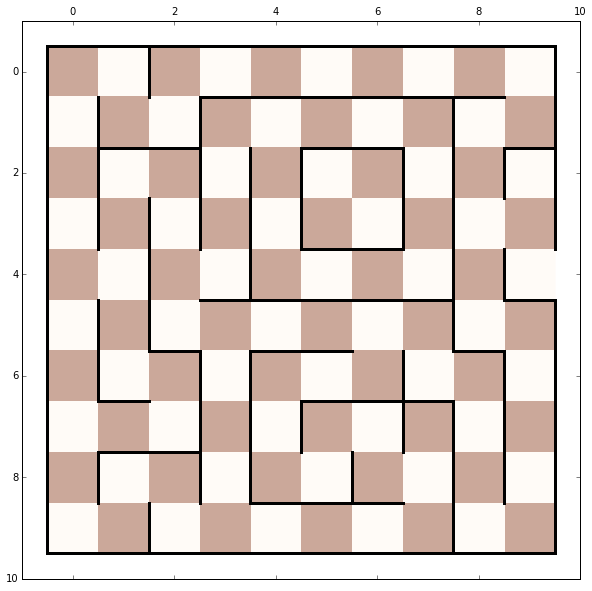

In [16]:
draw_tablero()